In [1]:
import sys
import os
import cv2
import random
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from force_utils import database, save_history, show_history

Using TensorFlow backend.


## MODEL

In [2]:
dataset = database('dataset/movie.mp4', 'dataset/forceinfo.csv')

In [3]:
timesteps = 20
height, width, channel = 9, 9, 512

In [4]:
input_shape = (299, 299, 3)
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=input_shape))

In [5]:
input_tensor = Input(shape=(timesteps, height, width, channel))
x = TimeDistributed(Flatten(input_shape=(height, width, channel)))(input_tensor)
x = LSTM(512, return_sequences=False, dropout=0.5)(x)
x = Dense(256, activation='relu')(x)
prediction = Dense(1)(x)
top_model = Model(inputs=input_tensor, outputs=prediction)
top_model.load_weights('dataset/weights/lstm_mae_01.h5')

In [6]:
frames, preds, errors = dataset.evaluate_lstm_model(input_shape, timesteps, base_model, top_model, 62000)

69820 / 69821

In [7]:
errors = np.array(dataset.errors)

In [8]:
np.sum(errors)

2801.1193298674825

In [9]:
np.mean(errors)

0.44286471618458223

## SHOW HISTOGRAM

In [12]:
# convolve
average = 59
conv_preds = np.convolve(preds, np.ones(average)/float(average), 'same')
conv_answer_vals = np.convolve(dataset.answer_vals, np.ones(average)/float(average), 'same')

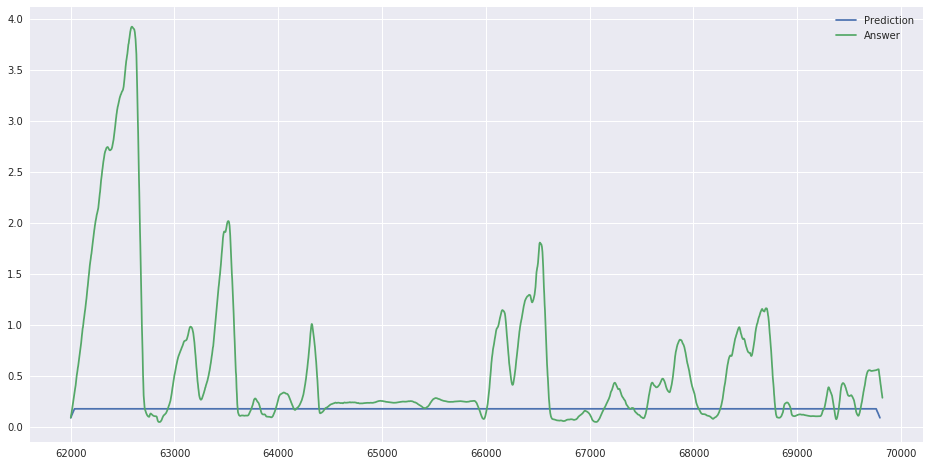

In [13]:
bins = 80
norm_hist = True

sns.set()
plt.figure(figsize=(16, 8))
plt.plot(frames[:-19], conv_preds, label='Prediction')
plt.plot(dataset.answer_keys, conv_answer_vals, label='Answer')
#plt.plot([65000, 65000], [4, 2], 'k-', lw=2)
# https://blog.amedama.jp/entry/2018/07/13/001155
#sns.distplot(preds, kde=False, bins=bins, norm_hist=norm_hist, label='Prediction')
#sns.distplot(answer_vals, kde=False, bins=bins, norm_hist=norm_hist, label='Answer')
#plt.xlabel('Confidence')
#plt.ylabel('Density')
plt.legend()

## SHOW MOVIE

In [8]:
video_file = './dataset/movie.mp4'
cap = cv2.VideoCapture(video_file)
# you should set start_frame to appropriate value(i.e start_frame)
cap.set(1, 18990) # within training
#cap.set(1, 55865) # start of validation
#cap.set(1, 62000)
font = cv2.FONT_HERSHEY_SIMPLEX
font_size = 15
features = []
max_frame = dataset.frame_count
max_force = np.max(force)

while(cap.isOpened()):
    ret, frame = cap.read()
    frame_num = cap.get(1)
    if frame_num > max_frame:
        break;
    img = Image.fromarray(np.uint8(frame[:,:,:])).resize((input_shape[0], input_shape[1]))
    img = np.asarray(img)
    img = img[np.newaxis, :, :, :]
    features.extend(base_model.predict(img / 255.0))
    if len(features) == timesteps:
        features_for_lstm = np.array(features)
        features = features[1:]
        features_for_lstm = features_for_lstm[np.newaxis,...]
        pred = model.predict(features_for_lstm)[0][0]
        force_meter = pred / max_force

        if pred > 3:
            color = (0,0,255)
        elif pred > 1.5:
            color = (0,255,0)
        else:
            color = (255,0,0)

        dst = cv2.rectangle(frame,
                            (int(frame.shape[1]*0.85), int(frame.shape[0]*(-0.6*force_meter+0.8))),
                            (int(frame.shape[1]*0.9), int(frame.shape[0]*0.8)),
                            color, -1)

        dst = cv2.putText(dst, str(np.round(pred, 3)),
                          (int(frame.shape[1]*0.85), int(frame.shape[0]*(-0.6*force_meter+0.78))),
                          font, 1, color, 2, cv2.LINE_AA)

        dst = cv2.putText(dst, str(int(frame_num)),
                          (int(frame.shape[1]*0.85), int(frame.shape[0]*0.85)),
                          font, 1, (255,255,255), 2, cv2.LINE_AA)

        cv2.imshow('frame', dst)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

## SHOW HISTORY

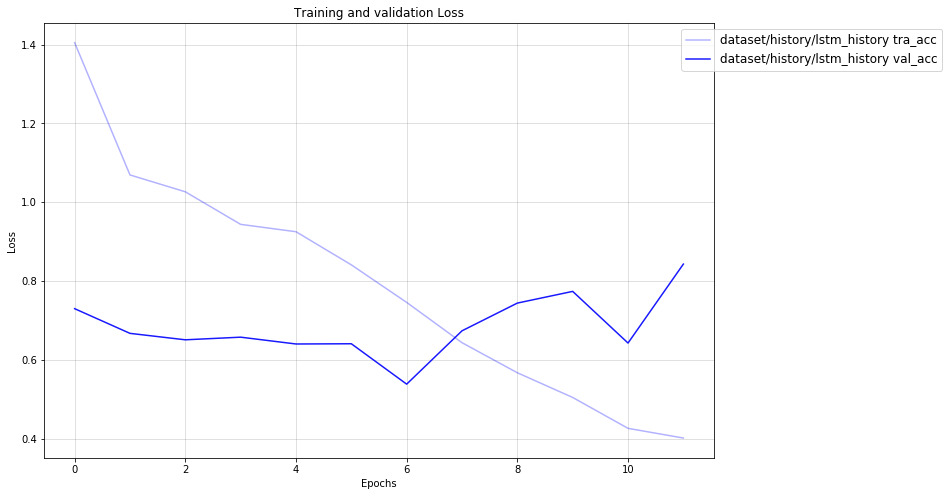

In [6]:
show_history(False, 'dataset/history/lstm_history.txt')